## Transformations in Political Economy - Technological Change and Populism (POL63102)
### Coding Session 6: Instrumental Variables (IV)

---
This document guides you through coding session 6. Please try to follow the instructions on your own PC and feel free to ask questions if something is unclear. After this session you should be able to do the following:

- Implement Instrumental Variables (IV) in Python
- Remove missing values from data
---

We load the full "house_2002_2016.dta" data set from Autor et al (2020) again:

In [1]:
import linearmodels.iv as iv
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from pathlib import Path
from stargazer.stargazer import Stargazer

df = pd.read_stata('C:/Users/felix/Dropbox/HfP/Teaching/SoSe21/Populism_Course/Autor_et_al_2020/2-FinalDataPackage/dta/house_2002_2016.dta')

Remember that the data contains amongst other the following variables:
- *d2_shnr_2002_Y* are the main outcome variables measuring the change in the Republican two-party vote share percentage between year 2002 and year Y = 2004, ..., 2016
- *d_imp_usch_pd* is the main independent variable for local labor market exposure to import competition from China
- *l_shind_manuf_cbp* is a control variable for manufacturing employment share
- *d_imp_otch_lag_pd* is the **shift-share instrumental variable** using Chinese exports to other countries

Recall that we can implement IV as 2SLS. The idea is to *isolate exogenous variation* in $X$ using the instrument $Z$.


- 1st Stage: obtain $\hat X$ from estimating:

\begin{gather*}
X=\pi_0 + \pi_1 Z + u
\end{gather*}



- 2nd Stage: Plug $\hat X$ in second stage:

\begin{gather*}
Y = \beta_0+\beta_1 \hat{X} +\epsilon
\end{gather*}



Let's first look at summary statistics of the variables:

In [2]:
df[["d2_shnr_2002_2016","d_imp_usch_pd", "l_shind_manuf_cbp", "d_imp_otch_lag_pd"]].describe().T

,count,mean,std,min,25%,50%,75%,max
d2_shnr_2002_2016,3767.0,8.358822,25.995949,-95.661407,-6.477878,6.811324,23.068745,100.000000
d_imp_usch_pd,3772.0,0.754591,0.652882,-0.259663,0.343260,0.623485,0.966137,6.079161
l_shind_manuf_cbp,3772.0,0.189763,0.097713,0.001083,0.115888,0.170197,0.257179,0.552423
d_imp_otch_lag_pd,3772.0,1.292206,1.078565,-0.191521,0.631572,1.014031,1.624856,7.395879


### First Stage

Let's first visualize the relationship between the variable of interest and the instrument using a binned scatter plot.

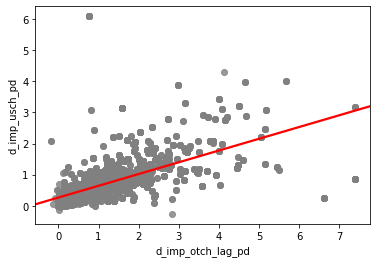

In [3]:
# Define y and x axis
y = df["d_imp_usch_pd"]
x = df["d_imp_otch_lag_pd"]

#create scatterplot with regression line (without confidence bands)
sns.regplot(x, y, ci=None, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

Note that for the first stage, all other independent variables need to be added to the right hand side as well:

In [4]:
reg_firststage = smf.ols(formula='d_imp_usch_pd ~ d_imp_otch_lag_pd + l_shind_manuf_cbp ', data=df).fit()
reg_firststage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          d_imp_usch_pd   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1961.
Date:                Sun, 13 Jun 2021   Prob (F-statistic):               0.00
Time:                        15:24:18   Log-Likelihood:                -2398.5
No. Observations:                3772   AIC:                             4803.
Df Residuals:                    3769   BIC:                             4822.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0815      0.016     -5.013      0.000      -0.113      -0.050
d_imp_otch_lag_pd     0.2185      0.009     25.344      0.000       0.202       0.235
l_shind_manuf_cbp     2.9184      0.095     30.672      0.000       2.732       3.105
==============================================================================
Omnibus:                     3338.460   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           209046.907
Skew:                           3.936   Prob(JB):                         0.00
Kurtosis:                      38.611   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Exercise:** Based on this output, what can you say about the relevance criterion of the instrument?

Let's obtain the fitted values from the first stage:

In [5]:
df['d_imp_usch_pd_fitted'] = reg_firststage.fittedvalues

In [6]:
df[['d_imp_usch_pd_fitted', 'd_imp_usch_pd']].describe().T

,count,mean,std,min,25%,50%,75%,max
d_imp_usch_pd_fitted,3772.0,0.754591,0.466212,-0.078375,0.416736,0.671922,1.023962,2.848157
d_imp_usch_pd,3772.0,0.754591,0.652882,-0.259663,0.343260,0.623485,0.966137,6.079161


### Second Stage

In [7]:
reg_secondstage = smf.ols(formula='d2_shnr_2002_2016 ~ d_imp_usch_pd_fitted  + l_shind_manuf_cbp', data=df).fit()
reg_secondstage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      d2_shnr_2002_2016   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     36.95
Date:                Sun, 13 Jun 2021   Prob (F-statistic):           1.28e-16
Time:                        15:24:18   Log-Likelihood:                -17581.
No. Observations:                3767   AIC:                         3.517e+04
Df Residuals:                    3764   BIC:                         3.519e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5866      0.931      1.704      0.088      -0.239       3.412
d_imp_usch_pd_fitted    -9.5264      2.223     -4.286      0.000     -13.884      -5.169
l_shind_manuf_cbp       73.5628     10.607      6.935      0.000      52.767      94.359
==============================================================================
Omnibus:                       71.652   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.096
Skew:                           0.155   Prob(JB):                     3.07e-27
Kurtosis:                       3.826   Cond. No.                         33.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Exercise:** How can this output be interpreted? How about standard errors?

### IV in one command

In [8]:
# help(iv.IV2SLS.from_formula)

Note that for this command to work, we need to make sure that the data we use does not contain *missing values*, indicated as "NA" in Python. You might come across this problem in your future research, so knowing how to deal with missing values is important. For more information, refer to https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html.

Let's consider our data set again:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3772 entries, 0 to 3771
Columns: 121 entries, congressionaldistrict to d_imp_usch_pd_fitted
dtypes: float32(116), float64(4), object(1)
memory usage: 1.8+ MB


How many entries are missing for our variables that we use in our analysis?

In [10]:
df[["d2_shnr_2002_2016","d_imp_usch_pd", "l_shind_manuf_cbp", "d_imp_otch_lag_pd"]].isna().sum()

d2_shnr_2002_2016    5
d_imp_usch_pd        0
l_shind_manuf_cbp    0
d_imp_otch_lag_pd    0
dtype: int64

Let's drop these observations with missing values.

In [11]:
df =df.dropna(subset= ["d2_shnr_2002_2016","d_imp_usch_pd", "l_shind_manuf_cbp", "d_imp_otch_lag_pd"])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3767 entries, 0 to 3771
Columns: 121 entries, congressionaldistrict to d_imp_usch_pd_fitted
dtypes: float32(116), float64(4), object(1)
memory usage: 1.8+ MB


Alright, we are now set to perfom IV regression in a single command.

In [13]:
reg_iv = iv.IV2SLS.from_formula(
    formula = 'd2_shnr_2002_2016 ~ 1 + [d_imp_usch_pd ~  d_imp_otch_lag_pd ] + l_shind_manuf_cbp',
    data=df).fit(cov_type='robust', debiased= True)

In [14]:
print(reg_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:      d2_shnr_2002_2016   R-squared:                      0.0069
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0064
No. Observations:                3767   F-statistic:                    36.375
Date:                Sun, Jun 13 2021   P-value (F-stat)                0.0000
Time:                        15:24:18   Distribution:                F(2,3764)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             1.5852     0.9147     1.7330     0.0832     -0.2081      3.3786
l_shind_manuf_cbp     73

In [15]:
print(reg_iv.first_stage)

     First Stage Estimation Results     
                           d_imp_usch_pd
----------------------------------------
R-squared                         0.5099
Partial R-squared                 0.1455
Shea's R-squared                  0.1455
Partial F-statistic               150.78
P-value (Partial F-stat)          0.0000
Partial F-stat Distn             chi2(1)
==========================   ===========
Intercept                        -0.0817
                               (-6.3243)
l_shind_manuf_cbp                 2.9194
                                (19.774)
d_imp_otch_lag_pd                 0.2184
                                (12.276)
----------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


Let's compare the IV results to the OLS results. Unfortunately, stargazer does only support results from the *statsmodels* module, not from *linearmodels*.

In [16]:
reg2 = smf.ols('d2_shnr_2002_2016 ~ d_imp_usch_pd + l_shind_manuf_cbp', data=df).fit(cov_type='HC1')

In [17]:
reg2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.0166,0.887,2.274,0.023,0.278,3.755
d_imp_usch_pd,-3.6655,0.773,-4.740,0.000,-5.181,-2.150
l_shind_manuf_cbp,47.9902,5.430,8.838,0.000,37.348,58.632


In [18]:
reg_iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,1.5852,0.9147,1.7330,0.0832,-0.2081,3.3786
l_shind_manuf_cbp,73.577,11.589,6.3487,0.0000,50.855,96.298
d_imp_usch_pd,-9.5281,2.4675,-3.8615,0.0001,-14.366,-4.6904


---
**Congratulations! This is the end of coding session 6.**